In [1]:
import torch
import numpy as np
import random
from torch import nn,tensor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchmetrics.classification import MulticlassAccuracy 
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import init
import fastcore.all as fc
from lib import *

In [2]:
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]


def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: # add bias if norm is not a BatchNormLayer
        bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: 
        layers.append(norm(nf))
    if act: 
        layers.append(act())
    return nn.Sequential(*layers)
# conv->LayerNorm->act


def get_model(act=nn.ReLU, nfs=None, norm=None):
    # nfs layer dims chain
    if nfs is None:
        nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, 
                         conv(nfs[-1], 10, act=None, norm=False, bias = True),
                         nn.Flatten()).to(device)             

In [3]:
device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
metrics = MetricCB(MulticlassAccuracy(10))
x,y = 'image','labe'
dsd = load_dataset("fashion_mnist")
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [4]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd # no normally distributed!

def normalize(b):
    return (b[0]-xmean)/xstd, b[1]

norm = BatchTransformCB(normalize) 

In [5]:
leak = 0.1
general_leaky_relu = partial(GeneralRelu, leak=leak, subtract=0.4)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu # ,
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 
f_init_weights = partial(init_weights, leaky=leak)

In [6]:
set_seed(42)
lr = 6e-2
n_epochs = 5
tmax = n_epochs * len(dls.train)

scheduler = partial(OneCycleLR, total_steps=tmax, max_lr=lr)

model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)

epochSched = BatchSchedCB(scheduler)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, epochSched]

learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.Adam)

In [7]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

MulticlassAccuracy,loss,epoch,train
0.771,0.645,0,train
0.828,0.521,0,eval
0.858,0.389,1,train
0.838,0.518,1,eval
0.886,0.312,2,train
0.878,0.335,2,eval
0.904,0.261,3,train
0.893,0.294,3,eval
0.919,0.221,4,train
0.895,0.284,4,eval


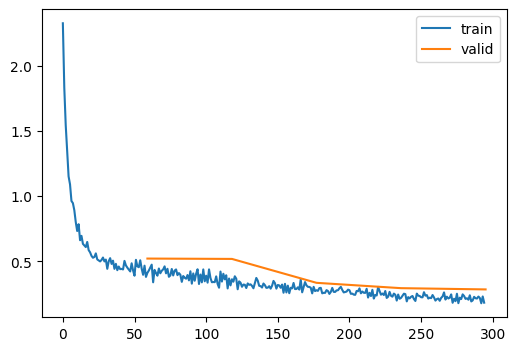

In [8]:
learn.fit(n_epochs)

# Going deeper:
Formula to compute conv2d layer outputs. It's the same for H or W:

$$ H' = floor \left( \frac{H + (2 * padding) - (\textit{kernels_size} * dilation) - 1}{stride} \right) + 1 $$

where default dilation = 1

Before we had:

initial H=28, padding=1, kernel_size=3, stride=2

- H' = (28+2*1-3*1-1)/2 + 1 = 14 -> after first conv2d
- ....
- H' = (3-2)/2 + 1 = 1 -> after last conv2d
- Final sequence of dimensions: [28, 14, 7, 3, 1] -> input dim + 4 layers

Now we want to add a layer at the end of the model so we modify the first layer of the cnn + append new conv2d layer.
If we use stride=1 instead of stride=2 in the first layer then the first layer will retain the input size instead of shrinking it:

- Final sequence of dimensions: [28, 28, 14, 7, 3, 1] -> input dim + 5 layers

# __IMPO if ks is odd and padding is 1 -> stride=1 retains input dim__

In [9]:
# Test1: stride =1, ks =3, padding = ks//2
img = xb[0].unsqueeze(0)
l = conv(1, 5, stride=1, act=None, norm=None, ks=3)   
out = l(img)
img.shape, out.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 5, 28, 28]))

In [10]:
# Test2: stride=1, ks=5, padding=ks//2
img = xb[0].unsqueeze(0)
l = conv(1, 5, stride=1, act=None, norm=None, ks=5)   
out = l(img)
img.shape, out.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 5, 28, 28]))

In [11]:
def get_model(act=nn.ReLU, nfs=[8, 16, 32, 64, 128], norm=None):
    layers = [conv(1, 8, act=act, norm=norm, stride=1)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, 
                         conv(nfs[-1], 10, act=None, norm=False, bias = True),
                         nn.Flatten()).to(device)             

MulticlassAccuracy,loss,epoch,train
0.796,0.576,0,train
0.794,0.773,0,eval
0.864,0.382,1,train
0.858,0.420,1,eval
0.899,0.276,2,train
0.887,0.317,2,eval
0.919,0.220,3,train
0.905,0.258,3,eval
0.940,0.164,4,train
0.913,0.242,4,eval


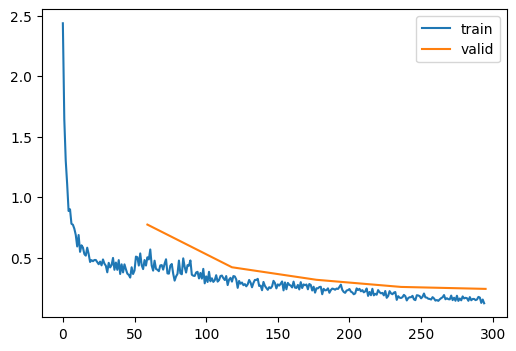

In [12]:
set_seed(42)
lr = 6e-2
n_epochs = 5
tmax = n_epochs * len(dls.train)

from torch.optim.lr_scheduler import OneCycleLR
scheduler = partial(OneCycleLR, total_steps=tmax, max_lr=lr)

model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)

epochSched = BatchSchedCB(scheduler)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, epochSched]

learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.Adam)
learn.fit(n_epochs)

With the correct initialization we have the chance to go deep!!
But if you go too deep you get vanishing/explosion gradients.
Think it in this way: a cnn with 56 conv layers is a superset of a a cnn with 20 conv layers, where the 36 layers have weights that are the Identity matrix!

# Shortcut/Skip connection

Idea: how do we change the training dynamics of the 56 layered cnn, s.t. make it (in terms of training dynamics) to the 20 layered cnn?
If the additional 36 additional layers are actually worsening the performance, then if we eg directly pass the input image again as input to the 36th layer we would have input -> 20 cnn layers -> output just as the 20 layered cnn!!

So le'ts suppose we have 2-layered cnn, then the output is:

> out = conv2d(conv2d(x))

Let's add x to both sides of equation:

> out + img = conv2d(conv2d(x)) + img

Which means that eg supposing that the two conv2d layers are "useless" ->  out + x = Null + x -> where out is Null cuz the two conv2d layers are "useless"; which makes sense!

The layers inbetween the sum input/output is called called res-block. It's called residual cuz by adding img to the right term we have:

> out = conv2d(conv2d(x)) + img

> out - img = conv2d(conv2d(x))

> residue(out, img) = conv2d(conv2d(x))

ISSUE: how can we sum the output of conv2d(conv2d(x)) and img if they have a different number of channels?? -> pass img into a "Identity"conv2d with 1x1 kernel_size.




In [13]:
conv2=conv(1, 5, stride=2, act=None, norm=nn.BatchNorm2d, ks=3)
conv2[1]

BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [14]:
init.constant_(conv2[1].weight, 0.)        

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

In [15]:
list(conv2[1].parameters())

[Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True)]

In [16]:
def _conv_block(ni, nf, stride, act=general_leaky_relu, norm=None, ks=3):
    ''' 
    Think to this _conv_block as if it is a single conv layer
    the first conv is a normal convolution, but it retains input dimensionality (h,w)
    the second conv is the one that applies the requested stride
        with the stride you get the dimensionality reduction on (h,w)
    '''    
    conv1=conv(ni, nf, stride=1, act=act, norm=norm, ks=ks)  
    conv2=conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks)    
    return nn.Sequential(conv1, conv2)

In [17]:
class ResBlock(nn.Module):
    '''
    here stride must be either 1 or 2
    '''
    def __init__(self, ni, nf, stride=1, ks=3, act=general_leaky_relu, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # this works only for stride=2
        self.act= act()
    
    def forward(self, x):
        # act fnc on the whole thing, that's why no act func in second conv in _conv_block
        return self.act(self.convs(x) + self.idconv(self.pool(x)))
    

The idea is the following. Let's start from:
> out = conv2d(conv2d(img)) + img

in the equation above if:
> conv2d(conv2d(img))

outputs all zeros then:

> out = img

That's what we achieve with the _conv_block with norm=BatchNorm.

So now we have solved the kill of conv2d(conv2d(x)). Now we need to solve the following issue: we have a number of filters in input and a number of filters in output. 
Suppose that img that is being summed and the image that is being passed to the two conv2d layers have the same number of channels/filter, then we only need to 
match the shape/n_filters/n_channels of the output of:

> conv2d(conv2d(img))

with the shape/n_filters/n_channels of img that is being summed.

So in ResBlock.\_\_init_\_() we have that if:

> if ni==nf -> then the img is just being forwarded to the sum operation

on the other hand:

> if ni != nf

then we need to apply an "identity convolution" that preserves the img content but matches the same of conv2d(conv2d(img)) cuz they have to be summed!
How to do so? -> let's start by applying a conv2d that outputs data of the same dimensionality of conv2d(conv2d(img)) using stride=1 and applies pooling to shrink H,W to make it match the H,W of the output of conv2d(conv2d(img)).
Actually we first do pooling to match shape (halving it in this example) then 
applying the identity conv with stride =1 s.t. keep the dimensionality obtained

In [18]:
def get_model(act=nn.ReLU, nfs=[8, 16, 32, 64, 128, 256], norm=None):
    layers = [ResBlock(1, 8, act=act, norm=norm, stride=1)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False)]
    layers += [nn.BatchNorm1d(10)] # optional but here works well    
    return nn.Sequential(*layers).to(device)             

# Let's create a hook to see input/output dimensionality of each layer

In [19]:
def _print_shape(hook, module, inpt, outpt):
    print(type(module).__name__, inpt[0].shape, outpt.shape)

In [20]:
model = get_model()

In [21]:
# just 1 batch to see dims
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])

In [22]:
with Hooks(_print_shape, model) as hooks:
    learn.fit(1, train=False)

ResBlock torch.Size([1024, 1, 28, 28]) torch.Size([1024, 8, 28, 28])
ResBlock torch.Size([1024, 8, 28, 28]) torch.Size([1024, 16, 14, 14])
ResBlock torch.Size([1024, 16, 14, 14]) torch.Size([1024, 32, 7, 7])
ResBlock torch.Size([1024, 32, 7, 7]) torch.Size([1024, 64, 4, 4])
ResBlock torch.Size([1024, 64, 4, 4]) torch.Size([1024, 128, 2, 2])
ResBlock torch.Size([1024, 128, 2, 2]) torch.Size([1024, 256, 1, 1])
Flatten torch.Size([1024, 256, 1, 1]) torch.Size([1024, 256])
Linear torch.Size([1024, 256]) torch.Size([1024, 10])
BatchNorm1d torch.Size([1024, 10]) torch.Size([1024, 10])


This is cool thus we patch it into the learner

In [23]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, module, inpt, outpt):
        nonlocal res, tot # look below
        nparms = sum(o.numel() for o in module.parameters())
        tot += nparms
        res += f'|{type(module).__name__}|{tuple(inpt[0].shape)}|{tuple(outpt.shape)}|{nparms}|\n'
    
    with Hooks(_f, self.model) as hooks:
        self.fit(1, train=False, cbs=[SingleBatchCB()])        
    print("Tot params: ", tot)
    
    if fc.IN_NOTEBOOK: 
        from IPython.display import Markdown
        return Markdown(res)
    else: 
        print(res)  

nonlocal: used inside a nested function to indicate that a variable being assigned to is in the nearest enclosing scope that is not global. This keyword allows you to work with variables in an outer (but not global) scope from within an inner function.

In [24]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).summary()

Tot params:  1226892


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|680|
|ResBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|3632|
|ResBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|14432|
|ResBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|57536|
|ResBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|229760|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|918272|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2560|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|


In [25]:
(9*8+1)*16 + ((9*16)+1)*16 + (9*16)

3632

# formula to compute number of params in conv block: 

>((ks_w *ks_h*cin)+1)*c_out

KeyboardInterrupt: 

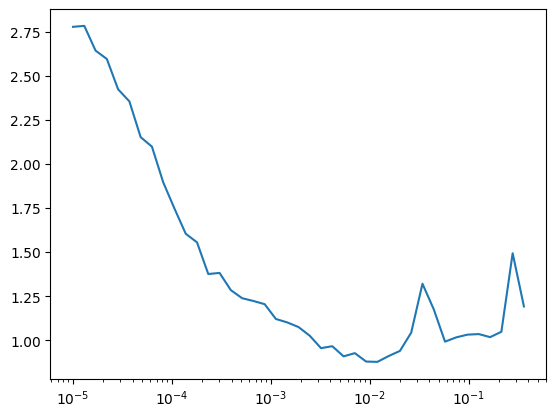

In [30]:
model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()], opt_func=optim.Adam).lr_find()

In [ ]:
set_seed(42)
lr = 6e-2
n_epochs = 5
tmax = n_epochs * len(dls.train)

from torch.optim.lr_scheduler import OneCycleLR
scheduler = partial(OneCycleLR, total_steps=tmax, max_lr=lr)

model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)

epochSched = BatchSchedCB(scheduler)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, epochSched]

learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.Adam)

In [ ]:
learn.fit(n_epochs)

In [ ]:
astats.plot_all()

In [ ]:
# let's try use a prebuilt model from timm
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck
' '.join(timm.list_models('*resnet*'))

In [ ]:
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(n_epochs)
